##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Свёрточная нейронная сеть (CNN)

В этом руководстве показано обучение простой [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) для классификации [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Поскольку в этом руководстве используется [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), для создания и обучения вашей модели потребуется всего несколько строк кода.


### Импорт TensorFlow

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Загрузка и подготовка набора данных CIFAR10

Набор данных CIFAR10 содержит 60 000 цветных изображений в 10 классах, по 6 000 изображений в каждом классе. Набор данных разделен на 50 000 обучающих изображений и 10 000 тестовых изображений. Классы взаимоисключающие и между ними нет пересечения.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Проверка данных

Чтобы убедиться, что набор данных выглядит правильно, давайте построим первые 25 изображений из обучающего набора и отобразим имя класса под каждым изображением:


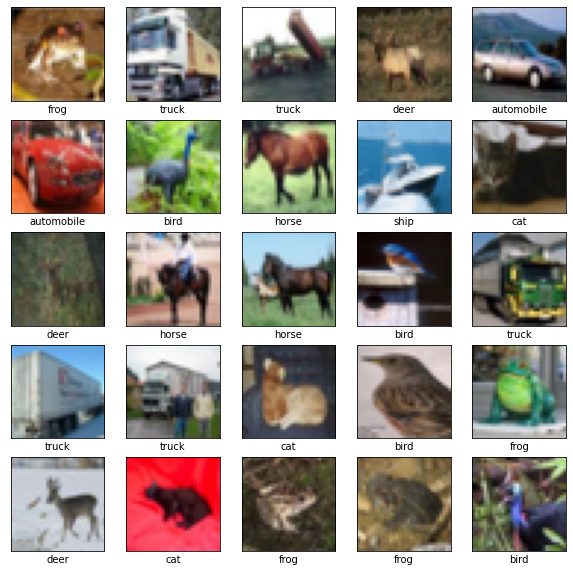

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Создание свёрточной базы

6 строк кода ниже определяют основу свертки, используя общий шаблон: стек [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) и [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

В качестве входных данных CNN принимает тензоры формы (image_height, image_width, color_channels), игнорируя размер пакета. Если вы новичок в этих измерениях, color_channels относится к (R, G, B). В этом примере вы настроите свою CNN для обработки входных данных формы (32, 32, 3), которая является форматом изображений CIFAR. Вы можете сделать это, передав аргумент `input_shape` вашему первому слою.


In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

2022-05-01 16:09:01.460581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 16:09:01.460606: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 16:09:01.460622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
2022-05-01 16:09:01.460789: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Давайте покажем архитектуру вашей модели на данный момент:

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

Выше вы можете видеть, что выходные данные каждого слоя Conv2D и MaxPooling2D представляют собой трехмерный тензор формы (высота, ширина, каналы). Размеры ширины и высоты имеют тенденцию уменьшаться по мере того, как вы углубляетесь в сеть. Количество выходных каналов для каждого слоя Conv2D управляется первым аргументом (например, 32 или 64). Как правило, по мере уменьшения ширины и высоты вы можете позволить (вычислительно) добавить больше выходных каналов в каждый слой Conv2D.

### Добавляем "плотные" слои наверх структуры

Чтобы завершить модель, вы передадите последний выходной тензор из сверточной базы (формы (4, 4, 64)) в один или несколько плотных слоев для выполнения классификации. Плотные слои принимают в качестве входных данных векторы (которые являются одномерными), а текущий вывод представляет собой трехмерный тензор. Сначала вы сгладите (или развернете) 3D-выход в 1D, а затем добавите один или несколько плотных слоев сверху. CIFAR имеет 10 выходных классов, поэтому вы используете последний плотный слой с 10 выходными данными.

In [6]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Вот полная архитектура модели:

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

Сводка по сети показывает, что выходные данные (4, 4, 64) были сглажены в векторы формы (1024) перед прохождением через два плотных слоя.

### Компиляция и обучения модели

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 18s 11ms/step - loss: 1.5308 - accuracy: 0.4426 - val_loss: 1.3197 - val_accuracy: 0.5189
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.1870 - accuracy: 0.5775 - val_loss: 1.1077 - val_accuracy: 0.6060
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.0431 - accuracy: 0.6365 - val_loss: 1.0864 - val_accuracy: 0.6143
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9530 - accuracy: 0.6665 - val_loss: 0.9862 - val_accuracy: 0.6522
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8790 - accuracy: 0.6914 - val_loss: 1.0043 - val_accuracy: 0.6498
Epoch 6/10
1563/1563 [==============================] - 16s 11ms/step - loss: 0.8231 - accuracy: 0.7118 - val_loss: 0.9047 - val_accuracy: 0.6894
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.7725 - accuracy: 0.7295 - val_loss: 0.8787 -

### Оценка модели

313/313 - 1s - loss: 0.8615 - accuracy: 0.7093 - 1s/epoch - 3ms/step


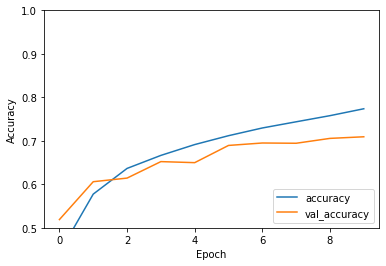

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [10]:
print(test_acc)

0.7092999815940857


Наша простая CNN достигла точности теста около 70%. Неплохо для нескольких строк кода! Для другого стиля CNN можно ознакомьтся с примером быстрого старта [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) , в котором используется API подклассов Keras и `tf.GradientTape`.